# **Retrieval Augmented Generation (RAG) 애플리케이션 구축: Part 2**

### 사용자와의 상호작용을 기억하는 메모리 기능과 다단계 검색(multi-step retrieval)을 통합한 RAG 애플리케이션을 구축

- **Part 1**: RAG 개념을 소개하고, 최소한의 구현 방법을 설명합니다.  
- **Part 2** 기존 구현을 확장하여 대화형 상호작용과 다단계 검색 프로세스를 처리할 수 있도록 개선합니다.

여기서는 **과거 대화 기록을 현재 답변 논리에 통합하는 방법**을 중점적으로 다룹니다.  

**두 가지 접근 방식**을 다룹니다.

1. **체인(Chains)**   - 한 번의 검색 단계만 실행합니다.  

2. **에이전트(Agents)**   - LLM이 필요에 따라 **여러 번의 검색 단계 (다중 단계 검색)** 를 수행하도록 자유롭게 설정합니다.

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# LangSmith 추적 설정 활성화
os.environ["LANGSMITH_TRACING"] = "true"

In [3]:
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

# 사용할 언어 모델의 이름을 지정
llm = ChatOpenAI(model="gpt-4o-mini")
# 사용할 임베딩 모델의 이름을 지정
embeddings = OpenAIEmbeddings(model='text-embedding-3-small')

In [4]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

우리가 콘텐츠를 불러올 웹사이트는  RAG Part 1 에서 사용했던 **[Lilian Weng의 "LLM 기반 자율 에이전트](https://lilianweng.github.io/posts/2023-06-23-agent/)" 블로그 게시물**이며, 이를 통해 해당 게시물의 내용에 대한 질문에 답 할 수 있도록 할 것입니다.  

In [5]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# HTML에서 `post-content`, `post-title`, `post-header` 클래스를 가진 콘텐츠만 추출하여 텍스트 변환
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))

# WebBaseLoader를 사용해 웹 페이지의 내용을 불러옵니다.
# Define the headers with a User-Agent
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer}
)

# 문서 로드하여 Document 객체 목록 반환
docs = loader.load()

# 로드된 문서가 정확히 하나인지 검증합니다.
assert len(docs) == 1

# 문서의 총 문자 수 출력
print(f"Total characters: {len(docs[0].page_content)}")

from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,            # 각 청크의 최대 문자 수 (1,000자)
    chunk_overlap=200,          # 청크 간 겹치는 문자 수 (200자)
    add_start_index=True,       # 원본 문서에서 각 청크의 시작 인덱스를 추적
)

# 불러온 문서를 설정한 기준에 따라 청크로 분할
all_splits = text_splitter.split_documents(docs)

# 분할된 청크(서브 문서)의 개수 출력
print(f"블로그 글을 {len(all_splits)}개의 하위 문서로 분할했습니다.")

# 분할된 문서 청크(all_splits)는 임베딩되어 벡터 스토어에 저장됩니다.
# 반환값은 저장된 각 문서 청크의 고유 ID 목록입니다.
_ = vector_store.add_documents(documents=all_splits)

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 43130
블로그 글을 66개의 하위 문서로 분할했습니다.


### LangChain 고유 방식 : Part 1 에서 사용했던 상태(state) 기반 접근법 
- LangChain의 **RAG 애플리케이션**에서는 사용자 입력, 검색된 문서, 그리고 생성된 답변을 각각 상태(state)라는 구조 안에 별도의 키(key)로 저장했습니다.  
- 예를 들면:  
   ```python
   state = {
       "question": "고양이는 몇 살까지 살아요?",
       "context": ["고양이의 평균 수명은 12-18년입니다."],
       "answer": "고양이는 보통 12-18년 정도 삽니다."
   }
   ```
- 하지만 이런 방식은 대화의 흐름을 자연스럽게 표현하기 어려울 수 있으므로 v0.3 부터는 OpenAI 의 메시지 형식을 활용하여 다음과 같은 방식을 권장합니다. 

---

### 새로운 메시지(messages) 기반 시퀀스 접근법 - OpenAI API 방식

- 여기에는 다음과 같은 요소들이 포함됩니다:  
   1. **사용자 메시지(User Message):** HumanMessage 로 표현
   2. **어시스턴트 메시지(Assistant Message):** AIMessage 로 표현  
   3. **도구 메시지(Tool Message):** 검색된 문서나 기타 참고 자료 - ToolMessage로 표현
   4. **최종 응답**: AIMessage 로 표현
      
<br>
- (참고) OpenAI API 방식:  

```python
messages = [
    {"role": "user", "content": "고양이는 몇 살까지 살아요?"},
    {"role": "tool", "content": "검색 결과: 고양이의 평균 수명은 12-18년입니다."},
    {"role": "assistant", "content": "고양이는 보통 12-18년 정도 삽니다."}
]
```
---

이 메시지 기반 시퀀스 모델 사용 편의를 위해, LangGraph에서는 내장된 MessagesState 버전을 제공합니다.

In [6]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

**도구 호출(tool-calling)** 을 활용해 검색 단계와 상호작용하는 것에는 또 다른 이점이 있습니다. 바로 **검색에 사용할 쿼리를 모델이 직접 생성할 수 있다는 점**입니다.  

이것은 특히 **대화형 환경(conversational setting)** 에서 중요합니다. 사용자의 질문이 **대화 이력(chat history)** 을 기반으로 문맥화되어야 할 수 있기 때문입니다. 

이 기능 역시 OpenAI API 의 tool calling 기능을 LangChain에서 활용하는 사례입니다.

---

### **예시 대화**  

> **Human:** "Task Decomposition이란 무엇인가요?"  
> **AI:** "Task Decomposition은 복잡한 작업을 더 작고 단순한 단계로 나누어, 에이전트나 모델이 더 쉽게 관리할 수 있도록 만드는 과정입니다."  
> **Human:** "일반적으로 Task Decomposition을 수행하는 방법에는 어떤 것들이 있나요?"  

- 이 시나리오에서 모델은 `"Task Decomposition의 일반적인 접근법"`과 같은 검색 쿼리를 생성할 수 있습니다.  
- **도구 호출(tool-calling)** 은 이런 과정을 자연스럽게 지원합니다.  

---

이제 검색 단계를 **도구(tool)** 로 전환해 보겠습니다.  

- response_format="content_and_artifact : 이 설정은 도구의 출력이 두 부분으로 구성됨을 나타냅니다:  
    콘텐츠(content): 모델이 처리할 수 있는 문자열 형태의 요약 또는 설명입니다.  
    아티팩트(artifact): 모델 외부에서 사용될 실제 데이터나 객체입니다.

In [7]:
from langchain_core.tools import tool

# 검색(retrieve) 함수를 도구로 정의
# - response_format="content_and_artifact": 결과를 콘텐츠(content)와 아티팩트(artifact)로 반환
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """
    주어진 쿼리와 관련된 정보를 검색합니다. 
    query: 검색할 텍스트 쿼리입니다. llm 이 생성해 줍니다.
    """    
    # 벡터 스토어에서 유사도 검색 수행. 가장 유사한 두 개의 문서를 반환.
    retrieved_docs = vector_store.similarity_search(query, k=2)
    
    # 검색된 문서를 문자열로 직렬화
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content {doc.page_content}")
        for doc in retrieved_docs
    )
    
    # 직렬화된 결과(content)와 원본 문서 목록(artifact) 반환.
    return serialized, retrieved_docs

우리의 그래프는 세 개의 노드로 구성됩니다:

1. **사용자 입력을 처리하는 노드**   
   - 검색을 위한 쿼리를 생성하거나, 직접 응답을 생성하는 역할을 합니다.  

2. **검색(retrieval) 도구를 실행하는 노드**    
   - 검색 단계를 수행하여 관련 문서를 가져오는 역할을 합니다.  

3. **최종 응답을 생성하는 노드**    
   - 검색된 문맥(context)을 활용하여 최종 답변을 생성합니다.  

아래에서 이 노드들을 구축하겠습니다.    
특히, **LangGraph의 사전 구축된 구성 요소 중 하나인 `ToolNode`를 활용**할 것입니다.    
이 `ToolNode`는 도구를 실행하고, 그 결과를 **`ToolMessage` 형태로 상태(state)에 추가**하는 역할을 합니다.   

In [17]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode

# 단계 1: 도구 호출을 포함할 수 있는 AIMessage를 생성하여 전송합니다.
def query_or_respond(state: MessagesState):
    """검색을 위한 도구 호출을 생성하거나 응답을 생성합니다."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState는 메시지를 덮어쓰지 않고 상태에 추가합니다.
    return {"messages": [response]}

# 단계 2: 검색을 실행합니다. (검색에 필요한 argument는 llm이 생성)
tools = ToolNode([retrieve])

# 단계 3: 검색된 내용을 사용하여 응답을 생성합니다. 
# (검색된 내용을 다시 llm에게 전달)
def generate(state: MessagesState):
    """답변을 생성합니다."""
    # 최근 생성된 ToolMessages 가져오기
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # 프롬프트 형식으로 변환
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "당신은 질문-응답 작업을 위한 어시스턴트입니다. "
        "다음의 검색된 문맥을 사용하여 질문에 답하세요. "
        "만약 답을 모른다면 모른다고 말하세요. "
        "최대 세 문장으로 답변하고 간결하게 유지하세요."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # 실행
    response = llm.invoke(prompt)
    return {"messages": [response]}

마지막으로, 우리의 애플리케이션을 단일 그래프 객체로 컴파일합니다. 이 경우, 우리는 단계를 순차적으로 연결합니다. 또한, 첫 번째 `query_or_respond` 단계가 "쇼트 서킷(어떤 조건이 충족되어 스킵)" 되어 도구 호출을 생성하지 않는 경우, 사용자에게 직접 응답할 수 있도록 허용합니다. 이를 통해 검색 단계가 필요하지 않은 일반적인 인사와 같은 대화 경험을 지원할 수 있습니다.

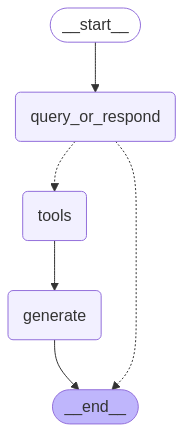

In [19]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

# 그래프 빌더에 각 노드 추가
graph_builder.add_node(query_or_respond)  # 쿼리 생성 또는 응답 노드 추가
graph_builder.add_node(tools)  # 검색(도구 호출) 노드 추가
graph_builder.add_node(generate)  # 최종 응답 생성 노드 추가

# 그래프의 시작점을 설정
graph_builder.set_entry_point("query_or_respond")

# 조건부 엣지(경로) 설정
graph_builder.add_conditional_edges(
    "query_or_respond",  # 첫 번째 노드: query_or_respond
    tools_condition,  # 조건 함수: 도구 호출이 필요한지 여부를 판단
    {END: END, "tools": "tools"},  # 조건에 따라 실행 경로 결정
    # - END: 도구 호출이 필요하지 않으면 실행 종료
    # - "tools": 검색이 필요하면 tools 노드로 이동
)

# 그래프 엣지(경로) 설정
graph_builder.add_edge("tools", "generate")  # 도구 검색 후 응답 생성 단계로 이동
graph_builder.add_edge("generate", END)  # 응답 생성 후 실행 종료

# 그래프 컴파일 및 출력
graph = graph_builder.compile()
graph

우리의 애플리케이션을 테스트해 봅시다.  

추가적인 검색 단계가 필요하지 않은 메시지에 적절하게 응답하는 것을 확인할 수 있습니다.

In [10]:
input_message = "안녕"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

안녕
================================== Ai Message ==================================

안녕하세요! 어떻게 도와드릴까요?


그리고 검색을 실행할 때, 쿼리 생성, 검색, 그리고 응답 생성 단계를 스트리밍하여 관찰할 수 있습니다.

In [11]:
input_message = "Task Decomposition이 뭐지요?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Task Decomposition이 뭐지요?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_0w15EdcgbSvKb9JULhPd8T9s)
 Call ID: call_0w15EdcgbSvKb9JULhPd8T9s
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}
Content Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n

### 대화 기록의 상태 기반 관리

실제 운영 환경에서는 Q&A 애플리케이션이 일반적으로 **대화 기록을 데이터베이스에 저장**하며, 이를 적절하게 읽고 업데이트할 수 있어야 합니다.  

LangGraph는 **내장된 지속성(persistence) 계층**을 구현하고 있어, 여러 번의 대화(turns)를 지원하는 챗봇 애플리케이션에 이상적입니다.  

여러 대화 턴과 스레드를 관리하려면, **애플리케이션을 컴파일할 때 체크포인터(checkpointer)를 지정**하기만 하면 됩니다.  
LangGraph의 노드들은 상태(state)에 메시지를 계속 추가하는 방식이므로, 호출할 때마다 일관된 대화 기록을 유지할 수 있습니다.  

LangGraph에는 **간단한 인메모리 체크포인터(in-memory checkpointer)**가 기본 제공되며, 아래 예제에서는 이를 사용합니다.  

In [12]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

이제 이전과 유사하게 호출할 수 있습니다.

In [13]:
input_message = "Task Decomposition이 뭐지요?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Task Decomposition이 뭐지요?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_jwrZDDpW3tRi9a7Kw9G6YcYQ)
 Call ID: call_jwrZDDpW3tRi9a7Kw9G6YcYQ
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}
Content Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n

In [14]:
input_message = "일반적인 방법을 찾아볼 수 있나요?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

일반적인 방법을 찾아볼 수 있나요?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_wfCKBCwBoK2NllRavDyiCk3N)
 Call ID: call_wfCKBCwBoK2NllRavDyiCk3N
  Args:
    query: 일반적인 Task Decomposition 방법
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}
Content Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ

---------------------------
모델이 두 번째 질문에서 생성한 쿼리는 대화의 문맥을 포함하고 있다는 점에 주목하세요.  

### **에이전트(Agents)**  

에이전트는 **대형 언어 모델(LLM)의 추론 능력을 활용하여 실행 중에 결정을 내리는 역할**을 합니다.  
에이전트를 사용하면 검색 프로세스에서 추가적인 판단을 LLM에게 위임할 수 있습니다.  

비록 앞서 설명한 "체인(chain)" 방식보다 동작이 예측 가능하지 않지만,  
에이전트는 **하나의 쿼리에 대해 여러 검색 단계를 실행하거나, 단일 검색을 반복적으로 개선할 수 있는 능력**을 갖추고 있습니다.  

아래에서는 **최소한의 RAG(Retrieval-Augmented Generation) 에이전트**를 구성합니다.  
LangGraph의 **사전 구축된 ReAct 에이전트 생성자**를 사용하면, 이를 단 한 줄의 코드로 구현할 수 있습니다.

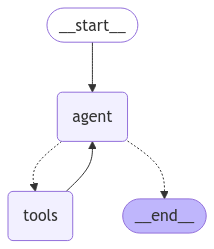

In [15]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)
agent_executor

이전 구현과의 핵심적인 차이점은, 실행이 최종 생성 단계에서 종료되는 대신, **도구 호출이 다시 원래 LLM 호출로 되돌아간다는 점**입니다.  
즉, 모델은 검색된 문맥을 사용하여 질문에 답할 수도 있고, 더 많은 정보를 얻기 위해 **또 다른 도구 호출을 생성할 수도 있습니다**.  

이제 이를 테스트해 보겠습니다.  
보통 여러 번의 검색 단계가 필요한 질문을 구성하여 확인해 보겠습니다.

In [16]:
config = {"configurable": {"thread_id": "def234"}}  

input_message = (
    "작업 분해(Task Decomposition)의 표준 방법은 무엇인가요?\n\n"
    "답을 찾으면, 해당 방법의 일반적인 확장 방식도 찾아보세요."
)  
# 사용자 입력 메시지 정의. 첫 번째 질문은 작업 분해의 표준 방법을 묻고,  
# 이후 해당 방법의 확장 방식까지 조사하도록 요청.
for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},  
    # 사용자 메시지를 포함한 입력을 에이전트 실행자(agent_executor)에 전달
    stream_mode="values",  # 스트리밍 모드 설정
    config=config,  # 설정 적용
):
    event["messages"][-1].pretty_print()  # 마지막 응답 메시지를 출력

================================ Human Message =================================

작업 분해(Task Decomposition)의 표준 방법은 무엇인가요?

답을 찾으면, 해당 방법의 일반적인 확장 방식도 찾아보세요.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_IQDw67ryvZR2mzy39rPMwdSr)
 Call ID: call_IQDw67ryvZR2mzy39rPMwdSr
  Args:
    query: 작업 분해(Task Decomposition) 표준 방법
  retrieve (call_pBQ4YOGk5xXvr0lfoiSO13Yw)
 Call ID: call_pBQ4YOGk5xXvr0lfoiSO13Yw
  Args:
    query: 작업 분해(Task Decomposition) 일반적인 확장 방식
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}
Content Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-

------------------------------
에이전트가 수행하는 과정은 다음과 같습니다:  

1. **작업 분해(Task Decomposition)의 표준 방법을 검색하기 위한 쿼리를 생성합니다.**  
2. **첫 번째 답변을 받은 후, 해당 방법의 일반적인 확장을 검색하는 두 번째 쿼리를 생성합니다.**  
3. **필요한 모든 문맥을 확보한 후, 최종적으로 질문에 대한 답변을 생성합니다.**  

LangSmith 추적을 통해 전체 실행 과정(쿼리 생성 → 검색 → 응답)과 함께 **지연 시간(latency) 및 기타 메타데이터**를 확인할 수 있습니다.